In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

from dataset import *
from vnet import *
from training import *
from niiutility import *
from loss import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, sampler, SubsetRandomSampler
from torchvision import transforms, utils

import torch.nn.functional as F  # useful stateless functions
import torchvision.transforms as T

#------------------------------- GLOBAL VARIABLES -------------------------------------#

USE_GPU = True
BATCH_SIZE = 1
NUM_WORKERS = 8
NUM_TRAIN = 259
LEARNING_RATE = 1e-2

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    print('using GPU for training')
else:
    device = torch.device('cpu')

using GPU for training


In [6]:
# filename = 'checkpoint2019-04-29 12:16:17.484157.pth'
filename = 'checkpoint2019-04-30 08_33_23.761098.pth'

checkpoint = torch.load(filename, map_location=torch.device('cpu'))
logger = checkpoint['logger']

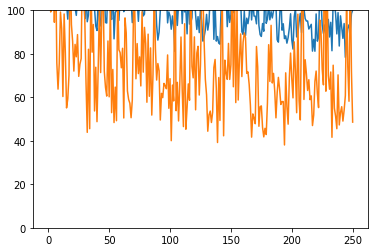

best validation loss is 38.092811584472656 in epoch 194
70.533295 23.52911


In [7]:
trainloss = logger['train']
epochs = len(trainloss)
valloss = [logger['validation'][i].numpy() for i in np.arange(epochs)]
plt.ylim(0, 100)
plt.plot (np.arange(epochs), trainloss)
plt.plot (np.arange(epochs), valloss)
plt.show()
print('best validation loss is {} in epoch {}'.format(np.min(valloss), np.argmin(valloss)))
print(np.mean(valloss[-50:]), np.std(valloss[-50:]))

In [8]:
regen = False

if regen:
    data_index = np.arange(370)
    data_idnex = np.stack ([np.random.shuffle(data_index[:259]),np.random.shuffle(data_index[259:])])
    print(list(data_index))
else:
    data_index = np.array ([120, 148, 24, 124, 200, 76, 159, 186, 125, 164, 251, 155, 0, 252, 238, 103, 53, 179, 244, 149, 45, 31, 131, 115, 82, 216, 130, 213, 245, 199, 229, 254, 56, 158, 32, 86, 221, 84, 81, 196, 117, 38, 28, 218, 257, 7, 237, 181, 105, 194, 16, 104, 75, 78, 249, 87, 144, 1, 183, 203, 54, 255, 129, 253, 202, 25, 34, 132, 80, 89, 137, 201, 114, 189, 110, 4, 71, 195, 97, 33, 157, 21, 250,
                            192, 258, 49, 47, 119, 191, 217, 143, 68, 190, 11, 176, 206, 108, 226, 50, 69, 118, 61, 35, 57, 243, 154, 15, 102, 146, 174, 163, 156, 233, 37, 180, 100, 184, 55, 239, 135, 151, 101, 205, 220, 169, 134, 228, 234, 51, 145, 29, 207, 141, 142, 44, 175, 12, 198, 52, 8, 30, 17, 10, 2, 126, 256, 40, 85, 46, 139, 178, 235, 23, 70, 188, 209, 93, 5, 153, 172, 127, 64, 241, 182, 18, 236, 187, 79, 210, 96,
                            3, 99, 63, 123, 171, 48, 6, 165, 43, 9, 230, 211, 19, 242, 162, 161, 173, 73, 106, 59, 136, 90, 112, 167, 246, 227, 109, 225, 41, 160, 133, 22, 177, 168, 14, 152, 107, 122, 223, 74, 62, 185, 222, 13, 150, 42, 212, 248, 147, 128, 67, 83, 214, 94, 98, 219, 232, 58, 247, 88, 66, 140, 116, 92, 113, 215, 27, 60, 138, 231, 39, 72, 166, 170, 91, 77, 224, 208, 240, 95, 26, 204, 197, 121, 36, 111, 193,
                            65, 20, 324, 330, 325, 262, 351, 366, 269, 365, 369, 297, 316, 363, 293, 267, 302, 313, 352, 307, 335, 290, 356, 286, 328, 320, 340, 333, 322, 355, 315, 296, 299, 312, 341, 261, 306, 282, 283, 292, 298, 321, 346, 310, 361, 265, 314, 331, 358, 305, 349, 276, 285, 368, 271, 317, 367, 336, 279, 275, 323, 277, 281, 337, 309, 260, 357, 266, 278, 294, 319, 332, 273, 303, 280, 284, 304, 334, 360, 300, 353, 308, 345, 364, 311, 270, 362, 339, 289, 342, 348, 263, 287, 274, 295, 327, 268, 272, 318, 354, 259, 329, 350, 359, 344, 338, 343, 288, 291, 347, 264, 326, 301])
    
dataset_trans = DatasetBV(data_index,
                         transform=transforms.Compose([
                             downSample(2),
                         ])
                     )

#-------------------------CREATE DATA LOADER FOR TRAIN AND VAL------------------------#

data_size = len(dataset_trans)
train_loader = DataLoader(dataset_trans, batch_size=BATCH_SIZE, \
                    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)),\
                    num_workers=NUM_WORKERS)
validation_loader = DataLoader(dataset_trans, batch_size=BATCH_SIZE,
                    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN,data_size)),\
                    num_workers=NUM_WORKERS)

In [ ]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(), \
          sample_batched['label'].size())
    show_batch_image(sample_batched['image'],BATCH_SIZE,None)
    print(sample_batched['label'])

    # observe 4th batch and stop.
    if i_batch == 3:
        break

In [9]:
# filename = 'checkpoint2019-04-29 21_27_35.242956.pth'
# filename = 'checkpoint2019-04-30 05_49_28.874396.pth'
filename  = 'checkpoint2019-05-01 09_49_28.653642.pth'
model = LNet(img_size=(128, 128, 128), out_size=6)

if os.path.isfile(filename):
    print("loading checkpoint '{}'".format(filename))
    checkpoint = torch.load(filename, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['state_dict'])
    print("loaded checkpoint '{}' (epoch {})"
        .format(filename, checkpoint['epoch']))
    
model = model.to(device=device)

loading checkpoint 'checkpoint2019-05-01 09_49_28.653642.pth'
loaded checkpoint 'checkpoint2019-05-01 09_49_28.653642.pth' (epoch 1051)


In [12]:
def check_bbox(model, dataloader, device, dtype, lossFun):
    model.eval() # set model to evaluation mode
    with torch.no_grad():
        loss = 0
        acc = 0
        size = 0
        misvolumn = 0
        N = len(dataloader)
        
        for t, batch in enumerate(dataloader):
            x = batch['image']
            y = batch['label']

            ytrue = y.cpu().numpy()

            x = x.to(device=device, dtype=dtype) # move to device,
            y = y.to(device=device, dtype=dtype)
            scores = model(x)

            yhatbef = scores.cpu().numpy()
            yhat = yhatbef
            '''
            yhat[:,0] = np.min(yhatbef[:,0:2], axis=1)
            yhat[:,1] = np.max(yhatbef[:,0:2], axis=1)

            yhat[:,2] = np.min(yhatbef[:,2:4], axis=1)
            yhat[:,3] = np.max(yhatbef[:,2:4], axis=1)

            yhat[:,4] = np.min(yhatbef[:,4:6], axis=1)
            yhat[:,5] = np.max(yhatbef[:,4:6], axis=1)
            '''
            
            xcenter = np.mean(yhat[:,0:2], axis=1)
            ycenter = np.mean(yhat[:,2:4], axis=1)
            zcenter = np.mean(yhat[:,4:6], axis=1)
            
            xcenter, ycenter, zcenter = np.clip ([xcenter, ycenter, zcenter], a_min=32, a_max=96)
           
            yhat[:,0] = xcenter - 32
            yhat[:,0] = np.max((yhat[:,0], 0))

            yhat[:,2] = ycenter - 32
            yhat[:,2] = np.max((yhat[:,2], 0))

            yhat[:,4] = zcenter - 32
            yhat[:,4] = np.max((yhat[:,4], 0))

            yhat[:,1] = xcenter + 32
            yhat[:,1] = np.min((yhat[:,1], 128))

            yhat[:,3] = ycenter + 32
            yhat[:,3] = np.min((yhat[:,3], 128))

            yhat[:,5] = zcenter + 32
            yhat[:,5] = np.min((yhat[:,5], 128))

            '''
            pad = 12
            padx = (yhat[:,1] - yhat[:,0])/2
            pady = (yhat[:,3] - yhat[:,2])/2
            padz = (yhat[:,5] - yhat[:,4])/2
            
            yhat[:,0] -= pad
            yhat[:,0] = np.max((yhat[:,0], 0))

            yhat[:,2] -= pad
            yhat[:,2] = np.max((yhat[:,2], 0))

            yhat[:,4] -= pad
            yhat[:,4] = np.max((yhat[:,4], 0))

            yhat[:,1] += pad
            yhat[:,1] = np.min((yhat[:,1], 128))

            yhat[:,3] += pad
            yhat[:,3] = np.min((yhat[:,3], 128))

            yhat[:,5] += pad
            yhat[:,5] = np.min((yhat[:,5], 128))
            '''
            
            yhat = np.round(yhat)

            full = (yhat[:,0] <= ytrue[:,0]) and (yhat[:,2] <= ytrue[:,2]) and (yhat[:,4] <= ytrue[:,4]) and \
                (yhat[:,1] >= ytrue[:,1]) and (yhat[:,3] >= ytrue[:,3]) and (yhat[:,5] >= ytrue[:,5])
            size += np.mean((yhat[:,1]-yhat[:,0], yhat[:,3]-yhat[:,2], yhat[:,5]-yhat[:,4]))
            
            if full:
                acc += 1
                print('img: ', t, 'correct', yhat[:,1]-yhat[:,0], yhat[:,3]-yhat[:,2], yhat[:,5]-yhat[:,4])
            else:
                print('img:', t, 'incorrect')

            if (yhat[:,0] <= ytrue[:,0]):
                pass
            else:
                misvolumn += (yhat[:,0]-ytrue[:,0])/(ytrue[:,1] - ytrue[:,0])
                print ((yhat[:,0]-ytrue[:,0])/(ytrue[:,1] - ytrue[:,0]))

            if (yhat[:,2] <= ytrue[:,2]):
                pass
            else:
                misvolumn += (yhat[:,2]-ytrue[:,2])/(ytrue[:,3] - ytrue[:,2])
                print ((yhat[:,2]-ytrue[:,2])/(ytrue[:,3] - ytrue[:,2]))
                
            if (yhat[:,4] <= ytrue[:,4]):
                pass
            else:
                misvolumn += (yhat[:,4]-ytrue[:,4])/(ytrue[:,5] - ytrue[:,4])
                print ((yhat[:,4]-ytrue[:,4])/(ytrue[:,5] - ytrue[:,4]))

            if (yhat[:,1] >= ytrue[:,1]):
                pass
            else:
                misvolumn += (ytrue[:,1]-yhat[:,1])/(ytrue[:,1] - ytrue[:,0])
                print ((ytrue[:,1]-yhat[:,1])/(ytrue[:,1] - ytrue[:,0]))

            if (yhat[:,3] >= ytrue[:,3]):
                pass
            else:
                misvolumn += (ytrue[:,3]-yhat[:,3])/(ytrue[:,3] - ytrue[:,2])
                print ((ytrue[:,3]-yhat[:,3])/(ytrue[:,3] - ytrue[:,2]))
                
            if (yhat[:,5] >= ytrue[:,5]):
                pass
            else:
                misvolumn += (ytrue[:,5]-yhat[:,5])/(ytrue[:,5] - ytrue[:,4])
                print ((ytrue[:,5]-yhat[:,5])/(ytrue[:,5] - ytrue[:,4]))

            loss += lossFun(scores, y)
            
        print(' validation loss = {0:.4f}, accuracy = {1:.4f}, size = {2:.4f}'.format (loss/N, acc/N, size/N))
        print(misvolumn/N)
        return loss/N

In [ ]:
check_bbox(model, train_loader, device, dtype, MSE)

In [13]:
check_bbox(model, validation_loader, device, dtype, MSE)

img:  0 correct [64.] [64.] [64.]
img:  1 correct [64.] [64.] [64.]
img:  2 correct [64.] [64.] [64.]
img:  3 correct [64.] [64.] [64.]
img:  4 correct [64.] [64.] [64.]
img:  5 correct [64.] [64.] [64.]
img:  6 correct [64.] [64.] [64.]
img:  7 correct [64.] [64.] [64.]
img:  8 correct [64.] [64.] [64.]
img:  9 correct [64.] [64.] [64.]
img:  10 correct [64.] [64.] [64.]
img:  11 correct [64.] [64.] [64.]
img:  12 correct [64.] [64.] [64.]
img:  13 correct [64.] [64.] [64.]
img:  14 correct [64.] [64.] [64.]
img:  15 correct [64.] [64.] [64.]
img:  16 correct [64.] [64.] [64.]
img:  17 correct [64.] [64.] [64.]
img:  18 correct [64.] [64.] [64.]
img:  19 correct [64.] [64.] [64.]
img:  20 correct [64.] [64.] [64.]
img:  21 correct [64.] [64.] [64.]
img:  22 correct [64.] [64.] [64.]
img:  23 correct [64.] [64.] [64.]
img:  24 correct [64.] [64.] [64.]
img:  25 correct [64.] [64.] [64.]
img:  26 correct [64.] [64.] [64.]
img:  27 correct [64.] [64.] [64.]
img:  28 correct [64.] [64.] [

tensor(45.7508, device='cuda:0')